In [ ]:
# 관련 라이브러리 선언
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

# 영상 출력을 위한 라이브러리
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [ ]:
# 이미지 전처리관련 연산 선언
# 이미지의 픽셀값을 (0~1)로 정규화 연산
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# RGB 영상을 YUV(YCbCr) 영상으로 변경하고 크기 조절 연산
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

In [ ]:
#초해상도 이미지를 줌인 영역과 함께 저장 및 표시
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # 새로운 이미지 생성
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # 줌인 인자: 2.0, 위치: 좌측상단
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # 경계 설정
    x1, x2, y1, y2 = 200, 300, 100, 200
    # x(가로방향) 제한 적용
    axins.set_xlim(x1, x2)
    # y(세로방향) 제한 적용
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # 경계라인 그리기
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

#초해상도 처리 이전의 영상 반환
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

#초해상도 처리된 이미지를 RGB 영상으로 반환
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0],
                                   np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge(
        "YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

In [ ]:
# BSDS300 데이터세트 url 지정 및 다운로드
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)

In [ ]:
# 다운로드 경로 및 추후 결과 출력 등을 위한 경로 설정
root_dir = os.path.join(data_dir, "BSDS500/data")
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

In [ ]:
# 다운로드된 데이터세트에서 학습과 테스트용 데이터세트 설정
crop_size = 100
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [ ]:
# 이미지의 정규화 수행
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

# 샘플 이미지 출력, 필요시 simlpe_visualize=True로 설정
simlpe_visualize = False
if(simlpe_visualize):
  for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

# 테스트 이미지의 경로 지정
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
# 이미지 데이터를 학습 및 테스트를 위하여 변환
# RGB 영상을 YUV영상으로 변환하고, Y 영역을 사용
# Y 영역을 BICCUBIC 보간법을 사용하여 지정된 크기로 변환
train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

# 원 이미지와 보간 처리된 이미지 출력, 필요시 simlpe_visualize=True로 설정
simlpe_visualize = False
if(simlpe_visualize):
  for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [ ]:
# 초해상도를 위한 인공신경망 설계
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

# 모델 생성 및 구조 출력
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

# 콜백함수 선언
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[2]),
                                         upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

# 학습에 사용할 콜백함수, 손실함수, 최적화함수 등 지정
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss",
                                                        patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [ESPCNCallback(), early_stopping_callback,
             model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, None, None, 4)     1156      
_________________________________________________________________
tf.nn.depth_to_space_9 (TFOp (None, None, None, 1)     0         
Total params: 58,212
Trainable params: 58,212
Non-trainable params: 0
_______________________________________________________

Epoch 1/50
50/50 - 13s - loss: 0.0752 - val_loss: 0.0530
Mean PSNR for epoch: 12.80


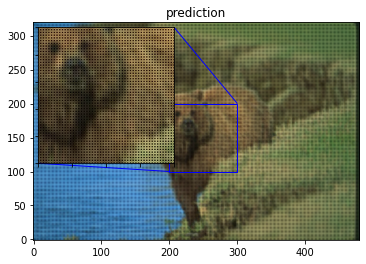

Epoch 2/50
50/50 - 13s - loss: 0.0108 - val_loss: 0.0057
Mean PSNR for epoch: 22.26
Epoch 3/50
50/50 - 13s - loss: 0.0058 - val_loss: 0.0047
Mean PSNR for epoch: 23.28
Epoch 4/50
50/50 - 13s - loss: 0.0052 - val_loss: 0.0045
Mean PSNR for epoch: 23.96
Epoch 5/50
50/50 - 13s - loss: 0.0050 - val_loss: 0.0044
Mean PSNR for epoch: 23.77
Epoch 6/50
50/50 - 13s - loss: 0.0050 - val_loss: 0.0044
Mean PSNR for epoch: 23.76
Epoch 7/50
50/50 - 13s - loss: 0.0050 - val_loss: 0.0044
Mean PSNR for epoch: 23.69
Epoch 8/50
50/50 - 13s - loss: 0.0049 - val_loss: 0.0043
Mean PSNR for epoch: 23.79
Epoch 9/50
50/50 - 13s - loss: 0.0049 - val_loss: 0.0043
Mean PSNR for epoch: 23.84
Epoch 10/50
50/50 - 13s - loss: 0.0049 - val_loss: 0.0043
Mean PSNR for epoch: 23.76
Epoch 11/50
50/50 - 13s - loss: 0.0049 - val_loss: 0.0044
Mean PSNR for epoch: 23.75
Epoch 12/50
50/50 - 13s - loss: 0.0049 - val_loss: 0.0043
Mean PSNR for epoch: 23.62
Epoch 13/50
50/50 - 13s - loss: 0.0048 - val_loss: 0.0043
Mean PSNR for e

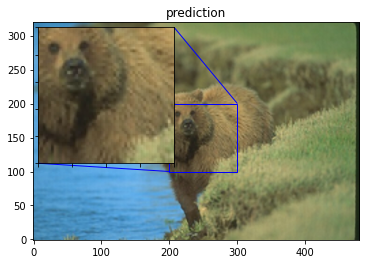

Epoch 22/50
50/50 - 12s - loss: 0.0048 - val_loss: 0.0042
Mean PSNR for epoch: 23.76
Epoch 23/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 24.00
Epoch 24/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 24.01
Epoch 25/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 24.41
Epoch 26/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 23.56
Epoch 27/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0042
Mean PSNR for epoch: 24.45
Epoch 28/50
50/50 - 12s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.05
Epoch 29/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0041
Mean PSNR for epoch: 24.16
Epoch 30/50
50/50 - 12s - loss: 0.0047 - val_loss: 0.0041
Mean PSNR for epoch: 23.73
Epoch 31/50
50/50 - 12s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 23.80
Epoch 32/50
50/50 - 12s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.01
Epoch 33/50
50/50 - 12s - loss: 0.0046 - val_loss: 0.0041
Mean PS

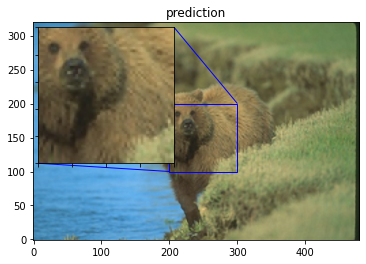

Epoch 42/50
50/50 - 13s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.05
Epoch 43/50
50/50 - 13s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.30
Epoch 44/50
50/50 - 13s - loss: 0.0047 - val_loss: 0.0044
Mean PSNR for epoch: 23.66
Epoch 45/50
50/50 - 13s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.03
Epoch 46/50
50/50 - 13s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 23.76
Epoch 47/50
50/50 - 13s - loss: 0.0045 - val_loss: 0.0041
Mean PSNR for epoch: 24.23
Epoch 48/50
50/50 - 12s - loss: 0.0045 - val_loss: 0.0041
Mean PSNR for epoch: 23.82
Epoch 49/50
50/50 - 12s - loss: 0.0045 - val_loss: 0.0041
Mean PSNR for epoch: 24.13
Epoch 50/50
50/50 - 12s - loss: 0.0046 - val_loss: 0.0041
Mean PSNR for epoch: 24.06


In [ ]:
# 훈련 실시
epochs = 50

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds,
    verbose=2
)

# 모델의 학습된 가중치 확인
model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 24.1667
PSNR of predict and high resolution is 24.7032


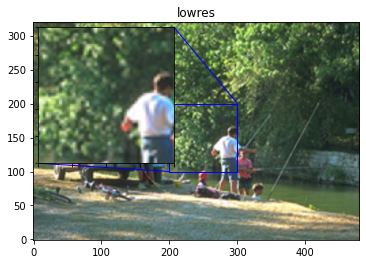

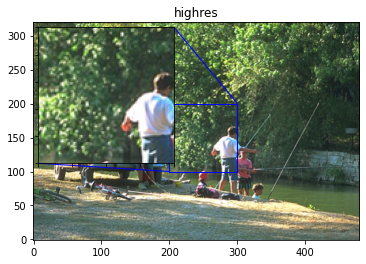

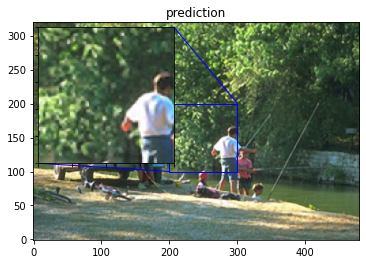

Avg. PSNR of lowres images is 2.4167
Avg. PSNR of reconstructions is 2.4703


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[6:7]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))